In [30]:
# Importing the required libraries

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
import json
!pip3 install flatten_json
from flatten_json import flatten
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [31]:
# Extracting the JSON file

dataset = pd.read_json("Dataset_Export.json")


In [32]:
# Creating the dataframe

dataset = pd.DataFrame(flatten(dataset.to_dict()).items())

In [33]:
# Processing the analytics data

dataset.rename(columns={0: 'Old', 1: 'New'}, inplace = True)
dataset[['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth']] = dataset['Old'].str.split("_", expand=True)

pd.options.mode.chained_assignment = None  # Disable the warning
db_analytics = dataset.loc[dataset["First"] == 'analytics']
db_analytics["Date"] = db_analytics[["Second", "Third", "Fourth"]].apply(lambda x: '-'.join(str(value) for value in x), axis=1)

db_analytics.rename(columns = {"Fifth":"Metric","New":"Value"}, inplace = True)
db_analytics.drop(columns =["Old","First","Second","Third","Fourth","Sixth"], inplace = True)
db_analytics.dropna(subset={"Value","Metric"})
db_analytics = db_analytics[["Date","Metric","Value"]]

db_analytics = db_analytics[~db_analytics['Date'].str.contains('None|Month', case=False, na=False)]
db_analytics = db_analytics[db_analytics["Metric"]=="totalUnitsGeneratedPerday"]


In [34]:
# Processing the readings data

db_readings = dataset.loc[dataset["First"] == 'readings']
db_readings['Type'] = db_readings[['Fourth', 'Fifth', 'Sixth']].apply(lambda x: '_'.join(str(value) for value in x), axis=1)
db_readings['New'] = db_readings['New'].replace('[a-zA-Z]', np.nan)
db_readings['New'] = db_readings['New'].replace('-', np.nan)
db_readings_1 = db_readings.copy()
db_readings_1["New"] = pd.to_numeric(db_readings_1["New"], errors='coerce')
db_readings_1['CombinedDateTime'] = pd.to_datetime(db_readings_1['Second'] + ' ' + db_readings_1['Third'], format='%Y-%m-%d %H:%M:%S')
db_readings_1["Type"] = db_readings_1["Type"].replace("_None","", regex=True)
db_readings_1.rename(columns = {"CombinedDateTime":"Date","Type":"Metric","New":"Value"}, inplace = True)
db_readings_1.drop(columns =["Old","First","Second","Third","Fourth","Fifth","Sixth"], inplace = True)
db_readings_final = db_readings_1[db_readings_1["Metric"]=="Units_Generated"]
db_readings_final_1 = db_readings_final.copy()



In [38]:
db_readings_final_1.head()

,Value
Date,
2023-05-18 13:48:23,18.92
2023-05-18 13:50:42,139.06
2023-05-18 13:52:39,155.95
2023-05-18 13:54:34,145.96
2023-05-18 13:56:28,143.54


In [42]:
# Summing up the readings data for 10 min interval

db_readings_final_1.set_index('Date', inplace=True)
db_readings_final_1.drop(columns =["Metric"], inplace = True)
result = db_readings_final_1.resample('10T').sum()

In [44]:
# Reading the CSV file

df = pd.read_csv('energycenterdata.csv')
df = df.drop(columns=['RECORD'])
df['CombinedDateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%Y %I:%M:%S %p')
result_df = pd.merge(df, result, left_on='CombinedDateTime', right_on='Date', how='inner')
result_df_1 = result_df[result_df['Value'].notnull()]

result_df_1.head()

,Date,Time,GHI_final,DNI_final,DHI_final,CMP_GHI_Avg,Sensor_Temp_Avg,Tair_Avg,RH_Avg,WS_WVc(1),...,Error_Max,IC_Max,GHI1_corr_Avg,DNI1_corr_Avg,DHI1_corr_Avg,GHI2_corr_Avg,DNI2_corr_Avg,DHI2_corr_Avg,CombinedDateTime,Value
0,7/17/2023,12:00:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.95,77.22,1.017,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:00:00,0.0
1,7/17/2023,12:10:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.91,77.33,1.117,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:10:00,0.0
2,7/17/2023,12:20:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.86,77.26,1.814,...,0,0,0.0,0.0,-0.044563,0.0,0.0,0.0,2023-07-17 00:20:00,0.0
3,7/17/2023,12:30:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.83,77.31,1.002,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:30:00,0.0
4,7/17/2023,12:40:00 AM,0.0,0.0,0.0,-1.266101,29.92,29.78,77.15,1.752,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:40:00,0.0


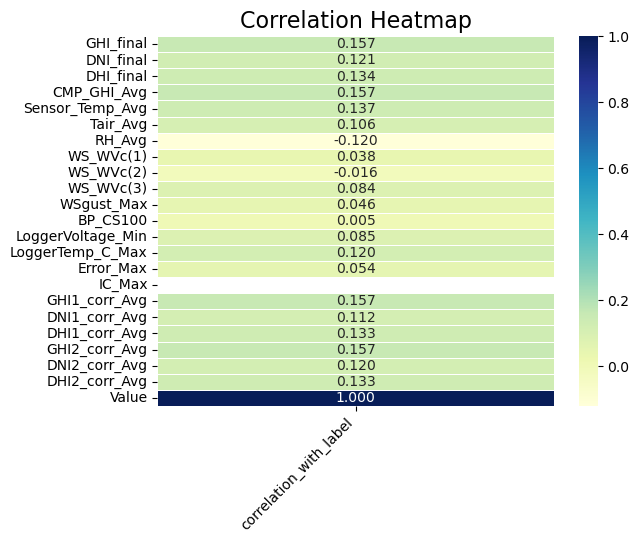

In [8]:
# Plotting the correlation heatmap

result_df_2 = result_df_1.drop(columns =["Date","Time","CombinedDateTime"])

correlation_matrix = result_df_2.corr()['Value'].to_frame(name='correlation_with_label')
correlation_matrix.sort_values(by="correlation_with_label")
heatmap = sns.heatmap(correlation_matrix, cmap='YlGnBu', annot=True, fmt=".3f", linewidths=.5)

heatmap.set_title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')

plt.show()
plt.show()

C:\Users\sheik\anaconda3\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


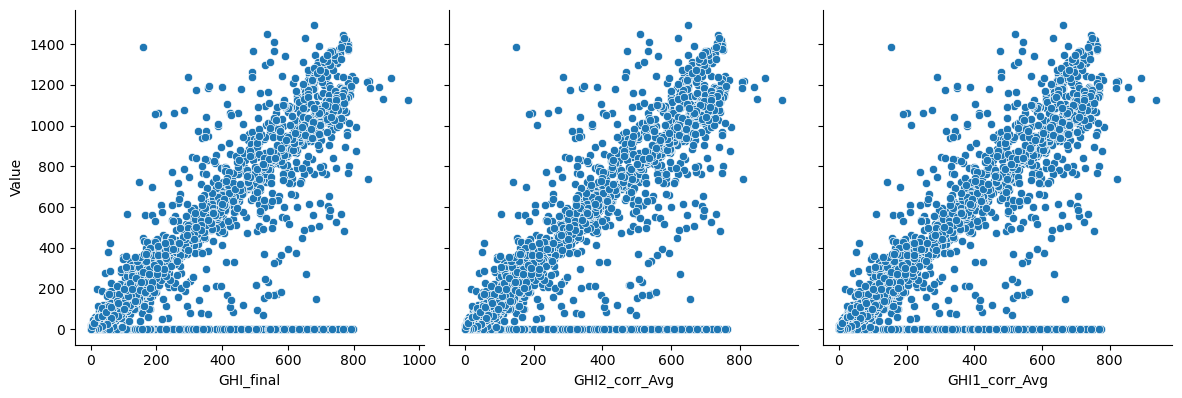

In [46]:
max_value_index = result_df_2['Value'].idxmax()

result_df_2 = result_df_2.drop(index=max_value_index)

sns.pairplot(result_df_2, x_vars=[ 'GHI_final', 'GHI2_corr_Avg','GHI1_corr_Avg' ], 
             y_vars = 'Value', size = 4, kind = 'scatter' )


In [10]:
# Performing the linear regression

X = result_df_1.drop(columns=["Value", "Date", "Time", "CombinedDateTime"])
y = result_df_1["Value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2_score(y_test, y_pred))


Coefficients: [-6.81890134e+03  6.25664659e+01  6.42463332e+02  1.32125706e+03
 -4.27453702e+02  2.83414952e+02 -1.72666658e+02  1.31314178e+02
 -3.99098280e+01 -4.63268344e+01 -1.82483995e+02  6.12943737e+01
  5.00134298e+01 -9.59570679e+01 -1.20877142e+01  2.36468622e-11
  6.80056713e+03 -1.08302489e+02 -4.34812722e+02 -5.09568657e+02
 -9.44472916e+01 -4.28336786e+02]
Intercept: 306.19907488986917
Mean Squared Error: 53201.19862577467
R-squared: 0.6754420341492395


GHI_final: -6818.901335073136
DNI_final: 62.5664658807527
DHI_final: 642.463331688332
CMP_GHI_Avg: 1321.2570638944248
Sensor_Temp_Avg: -427.45370203218613
Tair_Avg: 283.4149515773995
RH_Avg: -172.66665809493924
WS_WVc(1): 131.31417762574839
WS_WVc(2): -39.90982797601215
WS_WVc(3): -46.32683439900163
WSgust_Max: -182.48399546374958
BP_CS100: 61.294373657968436
LoggerVoltage_Min: 50.01342982614759
LoggerTemp_C_Max: -95.9570678778468
Error_Max: -12.087714188347823
IC_Max: 2.3646862246096134e-11
GHI1_corr_Avg: 6800.567125917066
DNI1_corr_Avg: -108.30248937002514
DHI1_corr_Avg: -434.81272197524277
GHI2_corr_Avg: -509.56865717201435
DNI2_corr_Avg: -94.44729163723294
DHI2_corr_Avg: -428.33678649405135


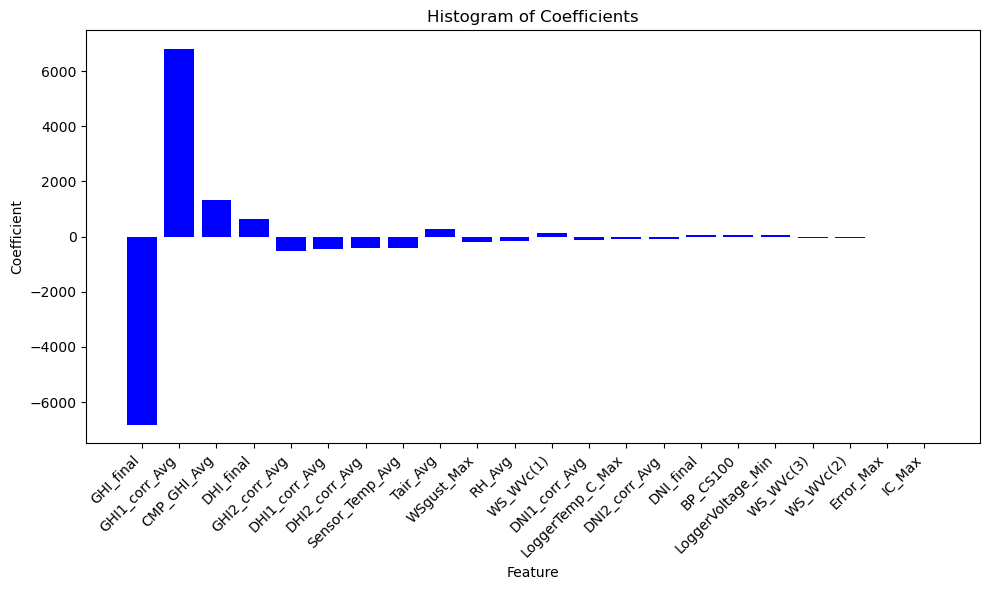

In [11]:
# Plotting the coefficients for input features

coefficients = model.coef_
feature_names = X_train.columns

feature_coefficients = dict(zip(feature_names, coefficients))

for feature, coefficient in feature_coefficients.items():
    print(f"{feature}: {coefficient}")

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df_sorted = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
plt.bar(coefficients_df_sorted['Feature'], coefficients_df_sorted['Coefficient'], color='blue')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Histogram of Coefficients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Removing the maximum value rows

max_value_index = result_df_1['Value'].idxmax()
result_df_1.drop(max_value_index, inplace=True)
result_df_1.head()

,Date,Time,GHI_final,DNI_final,DHI_final,CMP_GHI_Avg,Sensor_Temp_Avg,Tair_Avg,RH_Avg,WS_WVc(1),...,Error_Max,IC_Max,GHI1_corr_Avg,DNI1_corr_Avg,DHI1_corr_Avg,GHI2_corr_Avg,DNI2_corr_Avg,DHI2_corr_Avg,CombinedDateTime,Value
0,7/17/2023,12:00:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.95,77.22,1.017,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:00:00,0.0
1,7/17/2023,12:10:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.91,77.33,1.117,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:10:00,0.0
2,7/17/2023,12:20:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.86,77.26,1.814,...,0,0,0.0,0.0,-0.044563,0.0,0.0,0.0,2023-07-17 00:20:00,0.0
3,7/17/2023,12:30:00 AM,0.0,0.0,0.0,-1.661827,29.92,29.83,77.31,1.002,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:30:00,0.0
4,7/17/2023,12:40:00 AM,0.0,0.0,0.0,-1.266101,29.92,29.78,77.15,1.752,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,2023-07-17 00:40:00,0.0


In [13]:
# Implementing the Random forest model 

X = result_df_1.drop(columns=["Value", "Date", "Time", "CombinedDateTime"])
y = result_df_1["Value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

print("Feature Importances:", rf_model.feature_importances_)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error (Random Forest):", mse_rf)
print("R-squared (Random Forest):", r2_score(y_test, y_pred_rf))


Feature Importances: [0.08847785 0.00820741 0.01944395 0.48384255 0.0118026  0.02391189
 0.01604691 0.00930933 0.01138108 0.01383571 0.00721773 0.02678776
 0.00968244 0.01230316 0.00519458 0.         0.17085816 0.00733051
 0.01032801 0.0436177  0.00830735 0.01211333]
Mean Squared Error (Random Forest): 21917.872693081175
R-squared (Random Forest): 0.8669563477158115


In [14]:
# Performing hyperparameter tuning of the random forest model

X = result_df_1.drop(columns=["Value", "Date", "Time", "CombinedDateTime"])
y = result_df_1["Value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


grid_search.fit(X_train_scaled, y_train)


best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_


y_pred_best = best_rf_model.predict(X_test_scaled)


print("Best Parameters:", best_params)

mse_best = mean_squared_error(y_test, y_pred_best)
print("Mean Squared Error (Best Model):", mse_best)
print("R-squared (Best Model):", r2_score(y_test, y_pred_best))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error (Best Model): 21917.872693081175
R-squared (Best Model): 0.8669563477158115


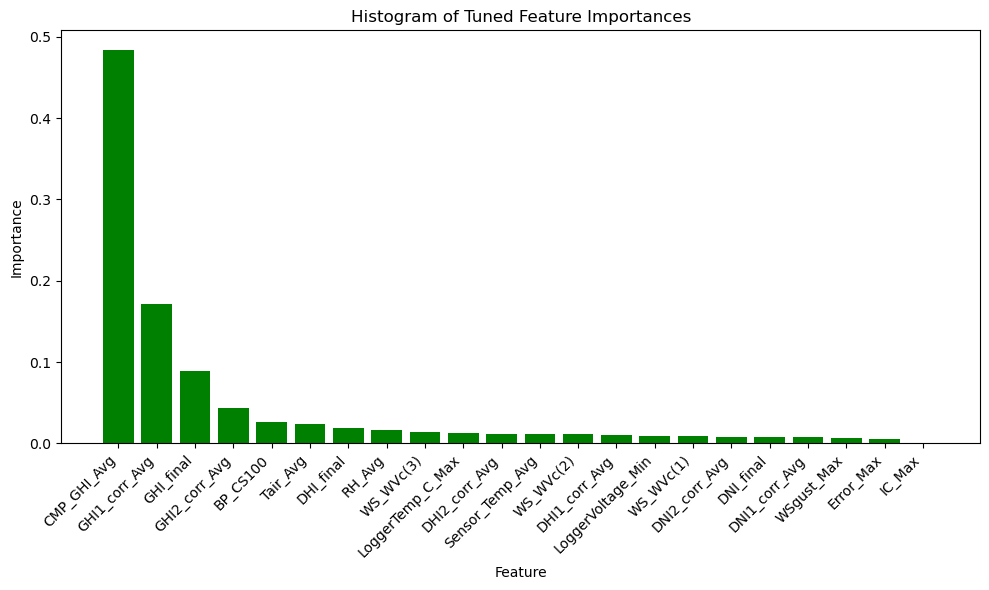

Tuned Feature Importances: [0.08847785 0.00820741 0.01944395 0.48384255 0.0118026  0.02391189
 0.01604691 0.00930933 0.01138108 0.01383571 0.00721773 0.02678776
 0.00968244 0.01230316 0.00519458 0.         0.17085816 0.00733051
 0.01032801 0.0436177  0.00830735 0.01211333]
Tuned Mean Squared Error: 21917.872693081175
Tuned R-squared: 0.8669563477158115


In [15]:
# Displaying the results 

feature_importances_tuned = best_rf_model.feature_importances_

feature_names = X.columns

importances_df_tuned = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_tuned})

importances_df_tuned_sorted = importances_df_tuned.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importances_df_tuned_sorted['Feature'], importances_df_tuned_sorted['Importance'], color='green')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Histogram of Tuned Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Tuned Feature Importances:", feature_importances_tuned)

y_pred_tuned = best_rf_model.predict(X_test_scaled)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print("Tuned Mean Squared Error:", mse_tuned)
print("Tuned R-squared:", r2_score(y_test, y_pred_tuned))


C:\Users\sheik\AppData\Local\Temp\ipykernel_9840\4193454018.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_aggregated = result_daily.resample('6H').sum()


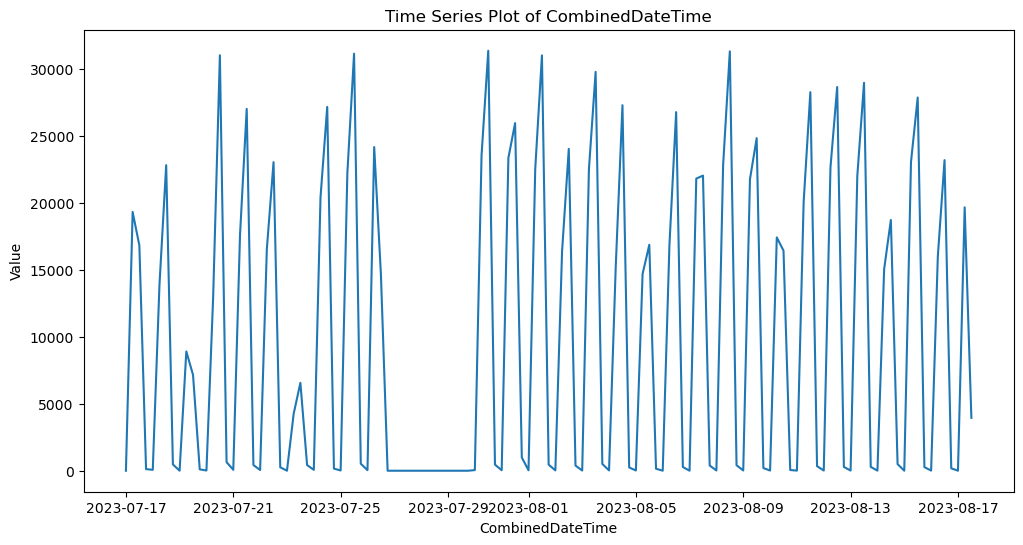

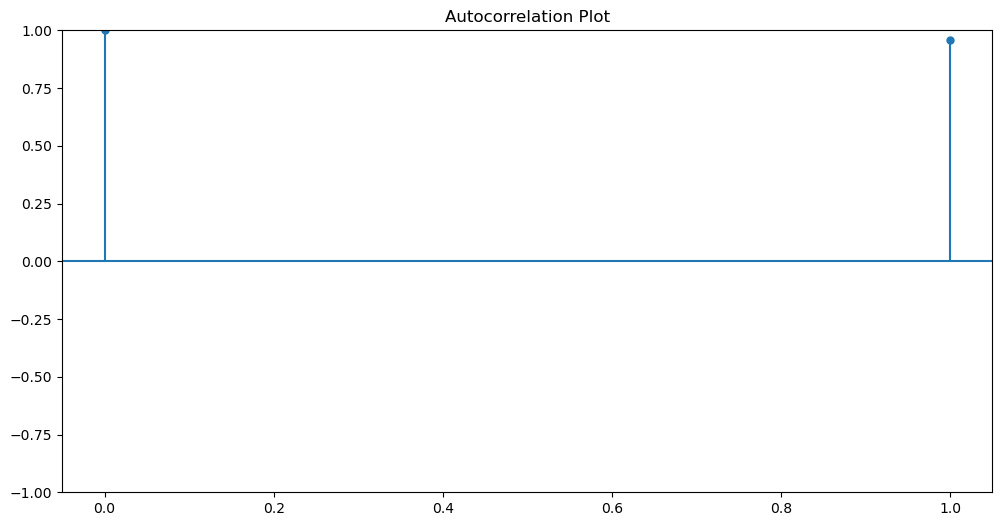

Autocorrelation at lag 1: 0.9586609037430865


In [16]:
# Performing the Time Series Analysis to determine the Autocorrelation

max_value_index = result_df_1['Value'].idxmax()
result_df_1.drop(max_value_index, inplace=True)
result_df_1.head()

result_daily = result_df_1.copy()
result_daily.set_index('CombinedDateTime', inplace=True)

daily_aggregated = result_daily.resample('6H').sum()

daily_aggregated.reset_index(inplace=True)

daily_aggregated.sort_values(by='CombinedDateTime', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(daily_aggregated['CombinedDateTime'], daily_aggregated['Value'], label='Units Generated')

plt.title('Time Series Plot of CombinedDateTime')
plt.xlabel('CombinedDateTime')
plt.ylabel('Value')

plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(result_df_1['Value'], lags=1, ax=ax)
plt.title('Autocorrelation Plot')
plt.show()

autocorrelation_values = acf(result_df_1['Value'], nlags=1)

print(f"Autocorrelation at lag {1}: {autocorrelation_values[1]}")